# Bias Score Calculator, an exploration 

As part of the team project, a bias scoring tool is required to be developed such that articles may be evaluated and provide the user an easy to interpret quantitative measure of the articles' factual quality.

Researching various APIs to find an already built tool to streamline and accelerate the protoyping process yielded little results with the only 'sentiment analysis' tools such as VADER being available. roughly testing it on news articles didnt show promise however.

To more thouroughly test its effectiveness and develop a final solution, this report is being written.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import display

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords

The following databses were taken from the github repository https://github.com/Media-Bias-Group/Neural-Media-Bias-Detection-Using-Distant-Supervision-With-BABE published by Timo Spinde, Manuel Plank, Jan-David Krieger, Terry Ruas, Bela Gipp, and Akiko Aizawa as part of their 'Neural Media Bias Detection Using Distant Supervision With BABE - Bias Annotations By Experts' research paper DOI: 10.18653/v1/2021.findings-emnlp.101 (https://aclanthology.org/2021.findings-emnlp.101/)

These databases include sentences from news articles with a respective 'bias'{'Non-biased', 'Biased', 'No agreement'} and 'opinion'{'Entirely factual', 'Somewhat factual but also opinionated', 'Expresses writer’s opinion', 'No agreement'} label given by majority vote from crowdsourcers, 8 'experts', and 5 'experts' respectively (experts as defined by the paper).

Since this is a published paper and preliminery perusal of the databases re-enforce the confidence in the database correctly analysing each sentence. Therefore, this will be used to test the various methods to quantify bias within articles.

In [26]:
# csv delimetered using ; instead of , need to adjust appropriately
db1 = pd.read_csv(filepath_or_buffer='final_labels_MBIC.csv', sep = ';')
# ['text', 'news_link', 'outlet', 'topic', 'type', 'group_id', 'num_sent', 'label_bias', 'label_opinion', 'article', 'biased_words']
db2 = pd.read_csv(filepath_or_buffer='final_labels_SG1.csv', sep = ';')
# ['text', 'news_link', 'outlet', 'topic', 'type', 'label_bias', 'label_opinion', 'biased_words']
db3 = pd.read_csv(filepath_or_buffer='final_labels_SG2.csv', sep = ';')
# ['text', 'news_link', 'outlet', 'topic', 'type', 'label_bias', 'label_opinion', 'biased_words']
print(db1.shape, db2.shape, db3.shape)
print(db1["text"].nunique(), db2["text"].nunique(), db3["text"].nunique())

(1700, 11) (1700, 8) (3674, 8)
1700 1700 3674


In [27]:
uniqueTextdb = pd.DataFrame(db1["text"].tolist() + db2["text"].tolist() + db3["text"].tolist())
print(uniqueTextdb.shape, uniqueTextdb.nunique())
# databases have duplicate data, db3 will be used

(7074, 1) 0    3682
dtype: int64


In [28]:
df = db3[["text", "label_bias", "label_opinion"]]
df.head(10)

,text,label_bias,label_opinion
0,"""Orange Is the New Black"" star Yael Stone is r...",Non-biased,Entirely factual
1,"""We have one beautiful law,"" Trump recently sa...",Biased,Somewhat factual but also opinionated
2,"...immigrants as criminals and eugenics, all o...",Biased,Expresses writer’s opinion
3,...we sounded the alarm in the early months of...,Biased,Somewhat factual but also opinionated
4,[Black Lives Matter] is essentially a non-fals...,Biased,Expresses writer’s opinion
5,[Democrats employ] their full arsenal to deleg...,Biased,Expresses writer’s opinion
6,[Newsoms's] obsession with masks has created a...,Biased,Expresses writer’s opinion
7,[Newsoms's] onslaught of propaganda ignores co...,Biased,Expresses writer’s opinion
8,[The police] now prefer to think of themselves...,Biased,Expresses writer’s opinion
9,‘A new low’: Washington Post media critic blow...,Biased,Expresses writer’s opinion


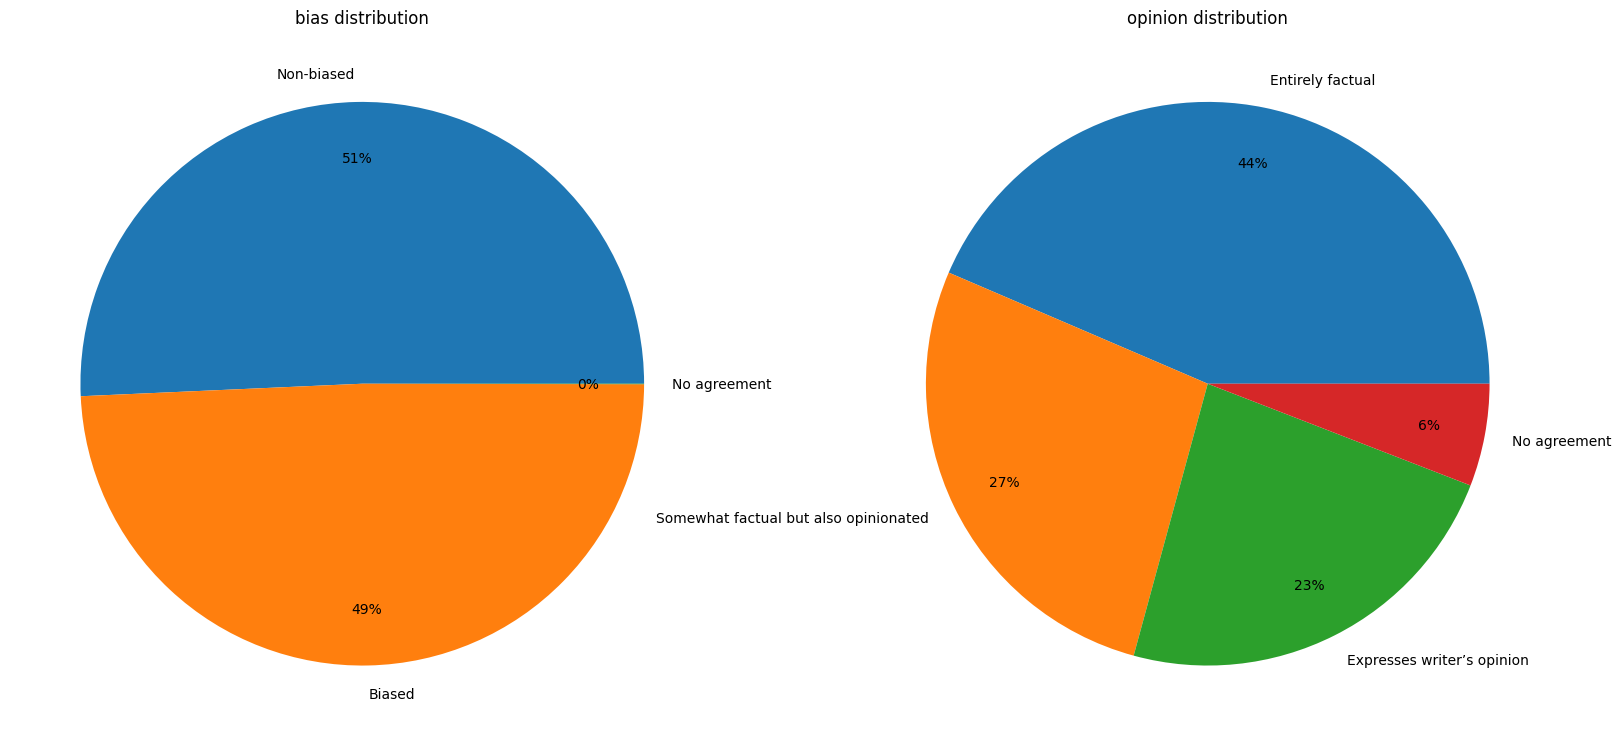

In [29]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))

bias_distribution = df["label_bias"].value_counts(dropna=False, normalize=True)
ax1.pie(bias_distribution, autopct='%1.0f%%', pctdistance=0.8, radius=1, labels=df["label_bias"].unique().tolist())
ax1.set_title("bias distribution")
opinion_distribution = df["label_opinion"].value_counts(dropna=False, normalize=True)
ax2.pie(opinion_distribution, autopct='%1.0f%%', pctdistance=0.8, radius=1, labels=df["label_opinion"].unique().tolist())
ax2.set_title("opinion distribution");

In [30]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as vaderSIA
sid_obj = vaderSIA()

biased = [[],[],[],[]]

for i in df.index:
    data = df.loc[i]
    sentiment_dict = sid_obj.polarity_scores(data["text"])
    for index, key in enumerate(sentiment_dict.keys()):
        value = 0
        if abs(sentiment_dict[key]) <= 0.5 and data["label_bias"] == "Non-biased":
            biased[index].append(1)
        else:
            biased[index].append(0)

print([sum(i)/len(i) for i in biased])

[0.5068045726728362, 0.0010887316276537834, 0.5070767555797496, 0.2901469787697333]


As none of the resultant values are >0.5 it indicates that the sentiment analysis is bad at predicting bias.

# Machine Learning method to classify bias and opinion
As the sentiment analysis didn't yield correct predictions of bias and as there are more than 2 (true, false) classes for 'opinion' (thus no logical/systematic way of classifying this using VADER); a more complex, machine learning based approach was devised.

As the labeled 3674 datapoints are too little to develop a large scale model, semi-suppervised gaussiam mixture model (provides the ability of clustering with partically labeled data as well as probability based alowing for a more granular quantitative evaluation) can be used in conjuction with unlabeled articles taken from the 'All the news' public database (https://www.kaggle.com/datasets/snapcrack/all-the-news?select=articles1.csv), providing >50000 articles (multiple sentences each).

The following DFD was developed to explain the following operations in developing the ML to predict both the bias and opinion of sentences in articles. This would then be used dynamically to calculate each 'new' article's biased and opinion score.

In [31]:
img = Image.open('MLDevelopmentFlowDiagram.png')
# display(img)

In [32]:
import re

def clean_text(text): 
    text = re.sub(r"<.*?>>*", " ", text) # removes html tags
    text = re.sub(r"&.*?;", " ", text) # removes html entities/symbols
    text = re.sub(r"[^A-Za-z']+", " ", text) # removes non-alphabetical characters
    text = re.sub(r" +", " ", text) # removes abnormal spaces introduced by previous regex
    text = text.lower().strip() # converts text to lowercase
    return text

In [33]:
random_state = np.random.RandomState(11)
X = df["text"].apply(clean_text)
y = df["label_bias"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=random_state)

In [34]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ashri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
vectorizer = CountVectorizer(stop_words=stop_words, max_df = 0.95)
vectorizer.fit(X_train)
X_train_BOW = vectorizer.transform(X_train)

In [36]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=random_state)
log_reg.fit(X_train_BOW, y_train)

X_test_BOW = vectorizer.transform(X_test) # get Bag of Words for test data
y_test_log_reg_predictions = log_reg.predict(X_test_BOW) # make prediction using log_reg object


# logistic regression confusion matrix
log_reg_cm = confusion_matrix(y_test, y_test_log_reg_predictions)
log_reg_TN, log_reg_FP, log_reg_FN, log_reg_TP = log_reg_cm.ravel()

log_reg_accuracy = accuracy_score(y_test, y_test_log_reg_predictions)
log_reg_precision = log_reg_TN/(log_reg_TN+log_reg_FN)
log_reg_recall = log_reg_TN/(log_reg_TN+log_reg_FP)
log_reg_f1 = f1_score(y_test, y_test_log_reg_predictions, pos_label='Non-biased')

print("Logisticregression:{{'accuracy':{0}, 'precision':{1}, 'recall':{2}, 'f1-score':{3}}}".format(
    log_reg_accuracy, log_reg_precision, log_reg_recall, log_reg_f1))

Logisticregression:{'accuracy':0.6899365367180417, 'precision':0.7173489278752436, 'recall':0.6513274336283186, 'f1-score':0.696808510638298}


In [39]:
from sklearn import svm

log_reg = svm.SVC(random_state=random_state)
log_reg.fit(X_train_BOW, y_train)

X_test_BOW = vectorizer.transform(X_test)
y_test_log_reg_predictions = log_reg.predict(X_test_BOW)

log_reg_cm = confusion_matrix(y_test, y_test_log_reg_predictions)
log_reg_TN, log_reg_FP, log_reg_FN, log_reg_TP = log_reg_cm.ravel()

log_reg_accuracy = accuracy_score(y_test, y_test_log_reg_predictions)
log_reg_precision = log_reg_TN/(log_reg_TN+log_reg_FN)
log_reg_recall = log_reg_TN/(log_reg_TN+log_reg_FP)
log_reg_f1 = f1_score(y_test, y_test_log_reg_predictions, pos_label='Non-biased')

print("Logisticregression:{{'accuracy':{0}, 'precision':{1}, 'recall':{2}, 'f1-score':{3}}}".format(
    log_reg_accuracy, log_reg_precision, log_reg_recall, log_reg_f1))

Logisticregression:{'accuracy':0.7171350861287398, 'precision':0.7304189435336976, 'recall':0.7097345132743362, 'f1-score':0.7142857142857143}


In [44]:
import pandas as pd
import numpy as np

db = pd.read_csv(filepath_or_buffer='final_labels_SG2.csv', sep = ';')
df = db[["text", "label_bias", "label_opinion"]]

random_state = np.random.RandomState(11)

import re

def clean_text(text): 
    text = re.sub(r"<.*?>>*", " ", text) # removes html tags
    text = re.sub(r"&.*?;", " ", text) # removes html entities/symbols
    text = re.sub(r"[^A-Za-z']+", " ", text) # removes non-alphabetical characters
    text = re.sub(r" +", " ", text) # removes abnormal spaces introduced by previous regex
    text = text.lower().strip() # converts text to lowercase
    return text

X = df["text"].apply(clean_text)
y_bias = df["label_bias"]
y_opinion = df["label_opinion"]

from sklearn.model_selection import train_test_split

X_train_bias, X_test_bias, y_train_bias, y_test_bias = train_test_split(X, y_bias, test_size=0.1, shuffle=True, random_state=random_state)
X_train_opinion, X_test_opinion, y_train_opinion, y_test_opinion = train_test_split(X, y_opinion, test_size=0.1, shuffle=True, random_state=random_state)

from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

vectorizer = CountVectorizer(stop_words=stop_words, max_df = 0.95)
vectorizer.fit(X_train_bias)
X_train_bias_BOW = vectorizer.transform(X_train_bias)
X_train_opinion_BOW = vectorizer.transform(X_train_opinion)

from sklearn import svm
svcBias = svm.SVC(random_state=random_state)
svcBias.fit(X_train_bias_BOW, y_train_bias)
svcOpinion = svm.SVC(random_state=random_state)
svcOpinion.fit(X_train_opinion_BOW, y_train_opinion)

import pickle
pickle.dump(vectorizer, open('vectorizer.sav', 'wb'))
pickle.dump(svcBias, open('svcBias.sav', 'wb'))
pickle.dump(svcOpinion, open('svcOpinion.sav', 'wb'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ashri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


SVC(random_state=RandomState(MT19937) at 0x226B1F91A40)

In [42]:
import pickle
loaded_vectorizer = pickle.load(open('vectorizer.sav', 'rb'))
loaded_svcBias = pickle.load(open('svcBias.sav', 'rb'))
loaded_svcOpinion = pickle.load(open('svcOpinion.sav', 'rb'))

X_test_bias_BOW = loaded_vectorizer.transform(X_test_bias)
y_test_bias_predictions = loaded_svcBias.predict(X_test_bias_BOW)